This dataset consists of 5547 breast histology images of size 50 x 50 x 3. The goal is to classify cancerous images (IDC : invasive ductal carcinoma) vs non-IDC images.

<img src="invasive_ductal_carcinoma_breast.jpg" alt="drawing" style="width: 200px;"/>

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import random
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #expand cell width
%matplotlib inline
np.random.seed(1)

In [2]:
#load data 
x = np.load('X.npy') 
y = np.load('Y.npy')

In [3]:
#show entire data vector
np.set_printoptions(threshold=np.nan)
#y


In [4]:
#randomize data
def shuffle(a,b):
    permutation = np.arange(0,len(a),1)
    np.random.shuffle(permutation)
    a_shuffled = a[permutation]
    b_shuffled = b[permutation]
    return(a_shuffled,b_shuffled)

x,y = shuffle(x,y)

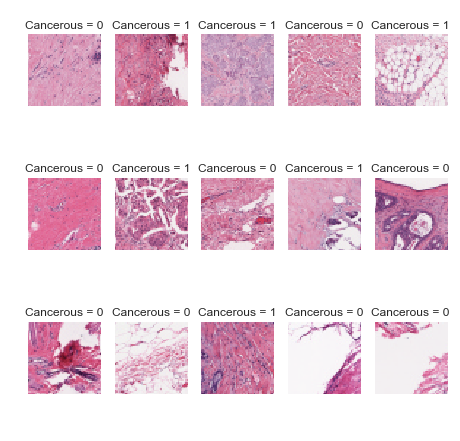

In [5]:
#Dataset: Image Examples
cols = 5
rows = 3
fig=plt.figure(figsize=(7.5,7.5))
for i in range(1,rows*cols+1):  
    plt.axis('off')
    fig.add_subplot(rows, cols, i)
    plt.title('Cancerous = %d' %y[i])
    plt.imshow(x[i])

plt.axis('off')
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [7]:
#One_hot_encoding 
Y_train = np.eye(2)[y_train.reshape(-1)]
Y_test = np.eye(2)[y_test.reshape(-1)]  
# Normalize image vectors
X_train = X_train/255
X_test = X_test/255

print("Total number of examples = " + str(len(x)))
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Total number of examples = 5547
Number of training examples = 4160
Number of test examples = 1387
X_train shape: (4160, 50, 50, 3)
Y_train shape: (4160, 2)
X_test shape: (1387, 50, 50, 3)
Y_test shape: (1387, 2)


In [8]:
def placeholders(height, width, channels, y): 
    X = tf.placeholder(tf.float32,[None,height,width,channels])
    Y = tf.placeholder(tf.float32,[None,y])
     
    return X, Y

In [9]:
def initialize_parameters():
    
    tf.set_random_seed(1)                             
    W1 = tf.get_variable("W1",[4,4,3,8],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    #W3 = tf.get_variable("W3",[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [10]:
def forward_propagation(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    print(Z1.get_shape())
    A1 = tf.nn.relu(Z1)
    print(Z1.get_shape())
    P1 = tf.nn.max_pool(A1,ksize= [1,8,8,1],strides=[1,8,8,1],padding="SAME")
    print(Z1.get_shape())
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    print()
    A2 = tf.nn.relu(Z2)
    print(tf.shape(A2))
    P2 = tf.nn.max_pool(A2,ksize= [1,4,4,1],strides=[1,4,4,1],padding="SAME")
    print(tf.shape(P2))
    P2_flatten = tf.contrib.layers.flatten(P2)
    print(tf.size(P2_flatten))
    Z3 = tf.contrib.layers.fully_connected(P2_flatten,2,activation_fn=None) #ac_fn=none => linear act
    
    
    return Z3

In [11]:
def compute_cost(Z3, Y): 
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y)) 
    return cost

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
  
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    
    #shuffle x,y
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 1000, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()   # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)               # to keep results consistent (tensorflow seed)
    seed = 3                            # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                      # To keep track of the cost
    

    X, Y = placeholders(n_H0, n_W0, n_C0,n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)  
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [15]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [19]:
#Flatten the training and test images
X_train = X_train.reshape(X_train.shape[0], -1).T 
X_test = X_test.reshape(X_test.shape[0], -1).T

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

number of training examples = 7500
number of test examples = 7500
X_train shape: (4160, 7500)
X_test shape: (1387, 7500)


In [20]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier().fit(X_train, y_train)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.75


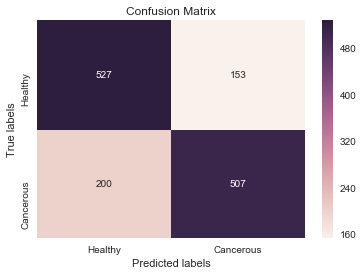

In [21]:
from sklearn.metrics import confusion_matrix
rf_predict = clf.predict(X_test)
rf_confusion = confusion_matrix(y_test, rf_predict)

plt.clf()
ax= plt.subplot()
sns.heatmap(rf_confusion,annot=True, ax = ax, fmt = 'g'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Healthy','Cancerous']); ax.yaxis.set_ticklabels(['Cancerous','Healthy']);
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_predict)) #, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.72      0.78      0.75       680
          1       0.77      0.72      0.74       707

avg / total       0.75      0.75      0.75      1387



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.79
